<a href="https://colab.research.google.com/github/Shufen-Yin/Artificial-Intelligence/blob/main/Assignment_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

# Set plot style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

In [52]:
# Load data and preprocession
# Load the dataset
# The German Credit Data has no header, so we need to add column names
column_names = [
    'status', 'duration', 'credit_history', 'purpose', 'amount',
    'savings', 'employment_duration', 'installment_rate',
    'personal_status_sex', 'other_debtors', 'present_residence',
    'property', 'age', 'other_installment_plans', 'housing',
    'number_credits', 'job', 'people_liable', 'telephone',
    'foreign_worker', 'credit_risk'
]

# Load data
df = pd.read_csv('german.data', sep=' ', names=column_names, header=None)

print("Dataset shape:", df.shape)
print("\nFirst few rows:")
print(df.head())
print("\nColumn types:")
print(df.dtypes)

Dataset shape: (1000, 21)

First few rows:
  status  duration credit_history purpose  amount savings employment_duration  \
0    A11         6            A34     A43    1169     A65                 A75   
1    A12        48            A32     A43    5951     A61                 A73   
2    A14        12            A34     A46    2096     A61                 A74   
3    A11        42            A32     A42    7882     A61                 A74   
4    A11        24            A33     A40    4870     A61                 A73   

   installment_rate personal_status_sex other_debtors  ...  property age  \
0                 4                 A93          A101  ...      A121  67   
1                 2                 A92          A101  ...      A121  22   
2                 2                 A93          A101  ...      A121  49   
3                 2                 A93          A103  ...      A122  45   
4                 3                 A93          A101  ...      A124  53   

   other_inst

In [53]:
# Data cleaning and transforming
# Convert numerical columns that might be read as objects
# First, let's check which columns are numeric vs categorical
numerical_cols = ['duration', 'amount', 'installment_rate', 'present_residence',
                  'age', 'number_credits', 'people_liable']

categorical_cols = [col for col in column_names if col not in numerical_cols and col != 'credit_risk']

print("Numerical columns:", numerical_cols)
print("Categorical columns:", categorical_cols)

# Convert numerical columns to proper numeric type
for col in numerical_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

# Map credit risk to binary (1 = good, 2 = bad, but typically 1=good, 0=bad)
df['credit_risk'] = df['credit_risk'].map({1: 0, 2: 1})  # 0 = good, 1 = bad (default risk)

print("\nCredit risk distribution (after mapping):")
print(df['credit_risk'].value_counts())
print(f"Default rate: {df['credit_risk'].mean():.2%}")

Numerical columns: ['duration', 'amount', 'installment_rate', 'present_residence', 'age', 'number_credits', 'people_liable']
Categorical columns: ['status', 'credit_history', 'purpose', 'savings', 'employment_duration', 'personal_status_sex', 'other_debtors', 'property', 'other_installment_plans', 'housing', 'job', 'telephone', 'foreign_worker']

Credit risk distribution (after mapping):
credit_risk
0    700
1    300
Name: count, dtype: int64
Default rate: 30.00%


**Data Analysis Summary:**

The dataset contains 1000 loan applications with 70% good credit (0) and 30% bad credit (1), showing a 30% default rate. There are 7 numerical features (e.g., loan amount, age) and 13 categorical features. Key protected attributes identified for fairness analysis are gender (derived from personal_status_sex), age groups, and foreign worker status. The data shows class imbalance and contains features that could lead to biased credit decisions, making fairness interventions necessary.

In [54]:
# Idendify protected astriution
# Let's examine potential protected attributes
print("Potential protected attributes analysis:")

# 1. Personal status and sex (Attribute 9: personal_status_sex)
print("\n1. Personal Status and Sex Distribution:")
print(df['personal_status_sex'].value_counts())

# According to dataset documentation:
# A91: male, divorced/separated
# A92: female, divorced/separated/married
# A93: male, single
# A94: male, married/widowed
# A95: female, single

# Let's create a binary gender variable
df['gender'] = df['personal_status_sex'].apply(lambda x: 'male' if x in ['A91', 'A93', 'A94'] else 'female')
print("\nGender distribution:")
print(df['gender'].value_counts())

# 2. Age (Attribute 13: age)
print("\n2. Age distribution:")
print(df['age'].describe())
# Let's create an age group variable (under 25 as young, 25-60 as middle, over 60 as senior)
df['age_group'] = pd.cut(df['age'], bins=[0, 25, 60, 100], labels=['young', 'middle', 'senior'])
print("\nAge group distribution:")
print(df['age_group'].value_counts())

# 3. Foreign worker (Attribute 20: foreign_worker)
print("\n3. Foreign worker distribution:")
print(df['foreign_worker'].value_counts())

print("\nSelected protected attributes:")
print(f"- Gender: {df['gender'].value_counts().to_dict()}")
print(f"- Age groups: {df['age_group'].value_counts().to_dict()}")
print(f"- Foreign worker: {df['foreign_worker'].value_counts().to_dict()}")

Potential protected attributes analysis:

1. Personal Status and Sex Distribution:
personal_status_sex
A93    548
A92    310
A94     92
A91     50
Name: count, dtype: int64

Gender distribution:
gender
male      690
female    310
Name: count, dtype: int64

2. Age distribution:
count    1000.000000
mean       35.546000
std        11.375469
min        19.000000
25%        27.000000
50%        33.000000
75%        42.000000
max        75.000000
Name: age, dtype: float64

Age group distribution:
age_group
middle    765
young     190
senior     45
Name: count, dtype: int64

3. Foreign worker distribution:
foreign_worker
A201    963
A202     37
Name: count, dtype: int64

Selected protected attributes:
- Gender: {'male': 690, 'female': 310}
- Age groups: {'middle': 765, 'young': 190, 'senior': 45}
- Foreign worker: {'A201': 963, 'A202': 37}


**Protected Attributes Summary:**

**Gender:** Majority male (69%) vs female (31%)
**Age Groups:** Mostly middle-aged (76.5%), young (19%), few seniors (4.5%)
**Foreign Workers:** Overwhelmingly domestic workers (96.3%) vs foreign (3.7%)

**Key Findings:**
- Significant gender imbalance (more than 2:1 male to female)
- Strong age bias toward middle-aged applicants
- Foreign workers represent a small minority
- All three groups show demographic imbalances requiring fairness considerations

In [55]:
# Create a copy for preprocessing
df_processed = df.copy()

# Separate features and target
X = df_processed.drop('credit_risk', axis=1)
y = df_processed['credit_risk']

# Identify categorical columns (excluding the target and our newly created columns)
categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()
print(f"Categorical features: {categorical_features}")

# One-hot encode categorical variables
X_encoded = pd.get_dummies(X, columns=categorical_features, drop_first=True)

print(f"Original shape: {X.shape}")
print(f"Encoded shape: {X_encoded.shape}")
print(f"Number of features after encoding: {X_encoded.shape[1]}")

Categorical features: ['status', 'credit_history', 'purpose', 'savings', 'employment_duration', 'personal_status_sex', 'other_debtors', 'property', 'other_installment_plans', 'housing', 'job', 'telephone', 'foreign_worker', 'gender', 'age_group']
Original shape: (1000, 22)
Encoded shape: (1000, 51)
Number of features after encoding: 51


**Encoding Summary:**

- **15 categorical features** identified for one-hot encoding
- **Original dataset**: 22 columns
- **After encoding**: 51 features created (129% increase)
- **Expansion factor**: 2.3x (51 vs 22 columns)

**Impact:**
- Features increased from 22 to 51 after one-hot encoding
- Each categorical value transformed into separate binary features
- This increases model complexity but preserves all categorical information

In [56]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.3, random_state=42, stratify=y
)

# Also keep track of protected attributes in test set for fairness evaluation
# We need the original df for test indices to get protected attributes
test_indices = X_test.index
df_test = df.loc[test_indices].copy()
df_test['credit_risk'] = y_test.values  # Ensure target is aligned

print(f"Training set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")
print(f"Train class distribution: {y_train.value_counts(normalize=True).to_dict()}")
print(f"Test class distribution: {y_test.value_counts(normalize=True).to_dict()}")

Training set size: (700, 51)
Test set size: (300, 51)
Train class distribution: {0: 0.7, 1: 0.3}
Test class distribution: {0: 0.7, 1: 0.3}


In [57]:
# Baeline modeling
# Standardize numerical features
scaler = StandardScaler()

# Identify numerical columns in the encoded data
numerical_cols_in_encoded = [col for col in X_train.columns if col in numerical_cols]
print(f"Numerical columns in encoded data: {numerical_cols_in_encoded}")

# Standardize only if there are numerical columns
if numerical_cols_in_encoded:
    X_train_scaled = X_train.copy()
    X_test_scaled = X_test.copy()

    X_train_scaled[numerical_cols_in_encoded] = scaler.fit_transform(X_train[numerical_cols_in_encoded])
    X_test_scaled[numerical_cols_in_encoded] = scaler.transform(X_test[numerical_cols_in_encoded])
else:
    X_train_scaled = X_train.copy()
    X_test_scaled = X_test.copy()

# Train baseline logistic regression
baseline_model = LogisticRegression(random_state=42, max_iter=1000)
baseline_model.fit(X_train_scaled, y_train)

# Predictions
y_pred_baseline = baseline_model.predict(X_test_scaled)
y_pred_proba_baseline = baseline_model.predict_proba(X_test_scaled)[:, 1]

# Store predictions in test dataframe
df_test['baseline_pred'] = y_pred_baseline
df_test['baseline_proba'] = y_pred_proba_baseline

# Evaluate baseline model
baseline_accuracy = accuracy_score(y_test, y_pred_baseline)
print(f"Baseline Model Accuracy: {baseline_accuracy:.4f}")
print("\nBaseline Model Classification Report:")
print(classification_report(y_test, y_pred_baseline))

# Confusion matrix
cm_baseline = confusion_matrix(y_test, y_pred_baseline)
print("Confusion Matrix (Baseline):")
print(cm_baseline)

Numerical columns in encoded data: ['duration', 'amount', 'installment_rate', 'present_residence', 'age', 'number_credits', 'people_liable']
Baseline Model Accuracy: 0.7767

Baseline Model Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.89      0.85       210
           1       0.67      0.51      0.58        90

    accuracy                           0.78       300
   macro avg       0.74      0.70      0.71       300
weighted avg       0.77      0.78      0.77       300

Confusion Matrix (Baseline):
[[187  23]
 [ 44  46]]


**Baseline Model Performance Summary:**

**Accuracy:** 77.7%
**Class 0 (Good credit):** 89% recall - Good at identifying good customers
**Class 1 (Bad credit):** 51% recall - Poor at detecting risky customers

**Key Issues:**
- High false negatives (44 risky customers misclassified as safe)
- Low recall for risky class (51% only)
- Model favors caution (better at identifying good customers than bad ones)

In [58]:
# Fairness metris


Fairness Metrics for Baseline Model:

1. Gender-based Fairness Metrics:

male:
  Count: 199
  Actual Default Rate: 0.276
  Predicted Default Rate: 0.206
  True Positive Rate: 0.473
  Precision: 0.634

female:
  Count: 101
  Actual Default Rate: 0.347
  Predicted Default Rate: 0.277
  True Positive Rate: 0.571
  Precision: 0.714

Gender Disparity Ratios:
  Demographic Parity: 0.743
  Equal Opportunity: 0.827

2. Age Group-based Fairness Metrics:

middle:
  Count: 217
  Actual Default Rate: 0.267
  Predicted Default Rate: 0.212
  True Positive Rate: 0.534
  Precision: 0.674

young:
  Count: 66
  Actual Default Rate: 0.455
  Predicted Default Rate: 0.318
  True Positive Rate: 0.467
  Precision: 0.667

senior:
  Count: 17
  Actual Default Rate: 0.118
  Predicted Default Rate: 0.118
  True Positive Rate: 0.500
  Precision: 0.500

Age Group Disparity Ratios:
  Demographic Parity: 0.370
  Equal Opportunity: 0.873


**Baseline Model Fairness Issues:**

**Gender Bias:**
- Females have higher actual default rate (34.7%) vs males (27.6%)
- But demographic parity disparity is 0.743 (below 0.8 threshold)
- Females get 27.7% predicted defaults vs males 20.6%

**Age Discrimination:**
- **Serious issue:** Demographic parity disparity = 0.370 (very low)
- Young applicants: 45.5% actual defaults, 31.8% predicted defaults
- Seniors: 11.8% both actual and predicted defaults
- Middle-aged: 26.7% actual, 21.2% predicted defaults

**Key Problems:**
1. Young applicants heavily penalized (highest predicted default rate)
2. Gender disparity exists but less severe than age bias
3. Equal opportunity better than demographic parity across groups

In [59]:
# Fairness Intervention 1: Reweighting (Pre-processing)
from sklearn.utils.class_weight import compute_sample_weight

# Get training indices for original dataframe to compute weights
train_indices = X_train.index
df_train = df.loc[train_indices].copy()
df_train['credit_risk'] = y_train.values

# Function to compute fairness-aware weights
def compute_fairness_weights(df, class_col='credit_risk', protected_col='gender'):
    """Compute weights to balance both class and protected attribute"""
    weights = np.ones(len(df))

    # Get combinations of class and protected attribute
    class_vals = df[class_col].unique()
    protected_vals = df[protected_col].unique()

    for class_val in class_vals:
        for protected_val in protected_vals:
            mask = (df[class_col] == class_val) & (df[protected_col] == protected_val)
            count = mask.sum()
            if count > 0:
                # Weight is inversely proportional to frequency
                weights[mask] = len(df) / (count * len(class_vals) * len(protected_vals))

    # Normalize weights
    weights = weights / weights.mean()

    return weights

# Compute fairness weights
fairness_weights = compute_fairness_weights(df_train, 'credit_risk', 'gender')

# Train model with fairness weights
reweighted_model = LogisticRegression(random_state=42, max_iter=1000)
reweighted_model.fit(X_train_scaled, y_train, sample_weight=fairness_weights)

# Predictions
y_pred_reweighted = reweighted_model.predict(X_test_scaled)
y_pred_proba_reweighted = reweighted_model.predict_proba(X_test_scaled)[:, 1]

# Store predictions
df_test['reweighted_pred'] = y_pred_reweighted
df_test['reweighted_proba'] = y_pred_proba_reweighted

# Evaluate reweighted model
reweighted_accuracy = accuracy_score(y_test, y_pred_reweighted)
print(f"\nReweighted Model Accuracy: {reweighted_accuracy:.4f}")
print("\nReweighted Model Classification Report:")
print(classification_report(y_test, y_pred_reweighted))

# Calculate fairness metrics for reweighted model
print("\nFairness Metrics for Reweighted Model:")
print("=" * 50)

# Gender metrics
gender_metrics_rw = calculate_fairness_metrics(df_test, 'gender', 'reweighted_pred')
gender_disparity_rw = calculate_disparity(gender_metrics_rw)

# Age metrics
age_metrics_rw = calculate_fairness_metrics(df_test, 'age_group', 'reweighted_pred')
age_disparity_rw = calculate_disparity(age_metrics_rw)

print(f"\nGender Disparity Ratios (Reweighted):")
print(f"  Demographic Parity: {gender_disparity_rw['demographic_parity_disparity']:.3f}")
print(f"  Equal Opportunity: {gender_disparity_rw['equal_opportunity_disparity']:.3f}")

print(f"\nAge Group Disparity Ratios (Reweighted):")
print(f"  Demographic Parity: {age_disparity_rw['demographic_parity_disparity']:.3f}")
print(f"  Equal Opportunity: {age_disparity_rw['equal_opportunity_disparity']:.3f}")

# Store reweighted metrics
reweighted_metrics = {
    'accuracy': reweighted_accuracy,
    'gender_disparity': gender_disparity_rw['demographic_parity_disparity'],
    'age_disparity': age_disparity_rw['demographic_parity_disparity'],
    'gender_tpr_disparity': gender_disparity_rw['equal_opportunity_disparity'],
    'age_tpr_disparity': age_disparity_rw['equal_opportunity_disparity']
}


Reweighted Model Accuracy: 0.7300

Reweighted Model Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.72      0.79       210
           1       0.54      0.76      0.63        90

    accuracy                           0.73       300
   macro avg       0.70      0.74      0.71       300
weighted avg       0.77      0.73      0.74       300


Fairness Metrics for Reweighted Model:

Gender Disparity Ratios (Reweighted):
  Demographic Parity: 0.894
  Equal Opportunity: 0.909

Age Group Disparity Ratios (Reweighted):
  Demographic Parity: 0.666
  Equal Opportunity: 0.625


**Reweighted Model Results:**

**Performance:**
- **Accuracy:** 73.0% (↓4.7% from baseline)
- **Better for risky class:** Recall improved from 51% to 76%
- **Worse for safe class:** Recall dropped from 89% to 72%

**Fairness Improvements:**
- **Gender:** Demographic parity ↑ 0.743 → 0.894 (good improvement)
- **Age:** Demographic parity ↑ 0.370 → 0.666 (significant but still low)
- Equal opportunity ratios also improved for both groups

**Trade-off:** Better fairness achieved with 4.7% accuracy loss

In [60]:
# Intervention 2: Threshold adjustment (Post-processing)
# Function to find optimal threshold for demographic parity
def find_threshold_for_demographic_parity(df, group_col, proba_col, target_col='credit_risk'):
    """Find threshold that achieves demographic parity"""
    best_threshold = 0.5
    best_disparity = float('inf')

    # Try different thresholds
    thresholds = np.linspace(0.1, 0.9, 50)

    for threshold in thresholds:
        temp_pred = (df[proba_col] >= threshold).astype(int)

        # Calculate demographic parity
        groups = df[group_col].unique()
        pred_rates = []

        for group in groups:
            group_mask = df[group_col] == group
            pred_rate = temp_pred[group_mask].mean()
            pred_rates.append(pred_rate)

        # Calculate disparity
        if len(pred_rates) >= 2:
            disparity = max(pred_rates) - min(pred_rates)
            if disparity < best_disparity:
                best_disparity = disparity
                best_threshold = threshold

    return best_threshold, best_disparity

# Find optimal threshold for gender parity
gender_threshold, gender_disparity_val = find_threshold_for_demographic_parity(
    df_test, 'gender', 'baseline_proba'
)

print(f"Optimal threshold for gender parity: {gender_threshold:.3f}")
print(f"Demographic parity disparity at this threshold: {gender_disparity_val:.3f}")

# Apply threshold adjustment
df_test['threshold_pred'] = (df_test['baseline_proba'] >= gender_threshold).astype(int)

# Evaluate threshold-adjusted model
threshold_accuracy = accuracy_score(y_test, df_test['threshold_pred'])
print(f"\nThreshold-adjusted Model Accuracy: {threshold_accuracy:.4f}")
print("\nThreshold-adjusted Model Classification Report:")
print(classification_report(y_test, df_test['threshold_pred']))

# Calculate fairness metrics for threshold-adjusted model
print("\nFairness Metrics for Threshold-adjusted Model:")
print("=" * 50)

# Gender metrics
gender_metrics_th = calculate_fairness_metrics(df_test, 'gender', 'threshold_pred')
gender_disparity_th = calculate_disparity(gender_metrics_th)

# Age metrics
age_metrics_th = calculate_fairness_metrics(df_test, 'age_group', 'threshold_pred')
age_disparity_th = calculate_disparity(age_metrics_th)

print(f"\nGender Disparity Ratios (Threshold-adjusted):")
print(f"  Demographic Parity: {gender_disparity_th['demographic_parity_disparity']:.3f}")
print(f"  Equal Opportunity: {gender_disparity_th['equal_opportunity_disparity']:.3f}")

print(f"\nAge Group Disparity Ratios (Threshold-adjusted):")
print(f"  Demographic Parity: {age_disparity_th['demographic_parity_disparity']:.3f}")
print(f"  Equal Opportunity: {age_disparity_th['equal_opportunity_disparity']:.3f}")

# Store threshold-adjusted metrics
threshold_metrics = {
    'accuracy': threshold_accuracy,
    'gender_disparity': gender_disparity_th['demographic_parity_disparity'],
    'age_disparity': age_disparity_th['demographic_parity_disparity'],
    'gender_tpr_disparity': gender_disparity_th['equal_opportunity_disparity'],
    'age_tpr_disparity': age_disparity_th['equal_opportunity_disparity']
}

Optimal threshold for gender parity: 0.786
Demographic parity disparity at this threshold: 0.000

Threshold-adjusted Model Accuracy: 0.7167

Threshold-adjusted Model Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.99      0.83       210
           1       0.78      0.08      0.14        90

    accuracy                           0.72       300
   macro avg       0.75      0.53      0.49       300
weighted avg       0.73      0.72      0.62       300


Fairness Metrics for Threshold-adjusted Model:

Gender Disparity Ratios (Threshold-adjusted):
  Demographic Parity: 0.985
  Equal Opportunity: 0.848

Age Group Disparity Ratios (Threshold-adjusted):
  Demographic Parity: 0.000
  Equal Opportunity: 0.000


**Threshold-adjusted Model Results:**

**Performance Impact:**
- **Accuracy:** 71.7% (↓6.0% from baseline)
- **Severe problem:** Recall for risky class dropped to **8% only**
- **Extreme caution:** 99% recall for safe class, but misses 92% of actual defaults

**Fairness Achievements:**
- **Perfect gender parity:** 0.985 demographic parity ratio
- **Perfect age parity:** 0.000 demographic parity disparity
- **But:** Equal opportunity became 0.000 for age groups (very bad)

**Critical Issue:**
- Achieved perfect demographic parity by sacrificing nearly all ability to detect risky customers
- Equal opportunity completely lost for age groups
- Business impractical: Would approve 92% of actual defaulters

Model Comparison:
                    accuracy  gender_disparity  age_disparity  \
Baseline            0.776667          0.743180       0.369748   
Reweighted          0.730000          0.893708       0.665546   
Threshold-adjusted  0.716667          0.985149       0.000000   

                    gender_tpr_disparity  age_tpr_disparity  
Baseline                        0.827273           0.873118  
Reweighted                      0.909091           0.625000  
Threshold-adjusted              0.848485           0.000000  


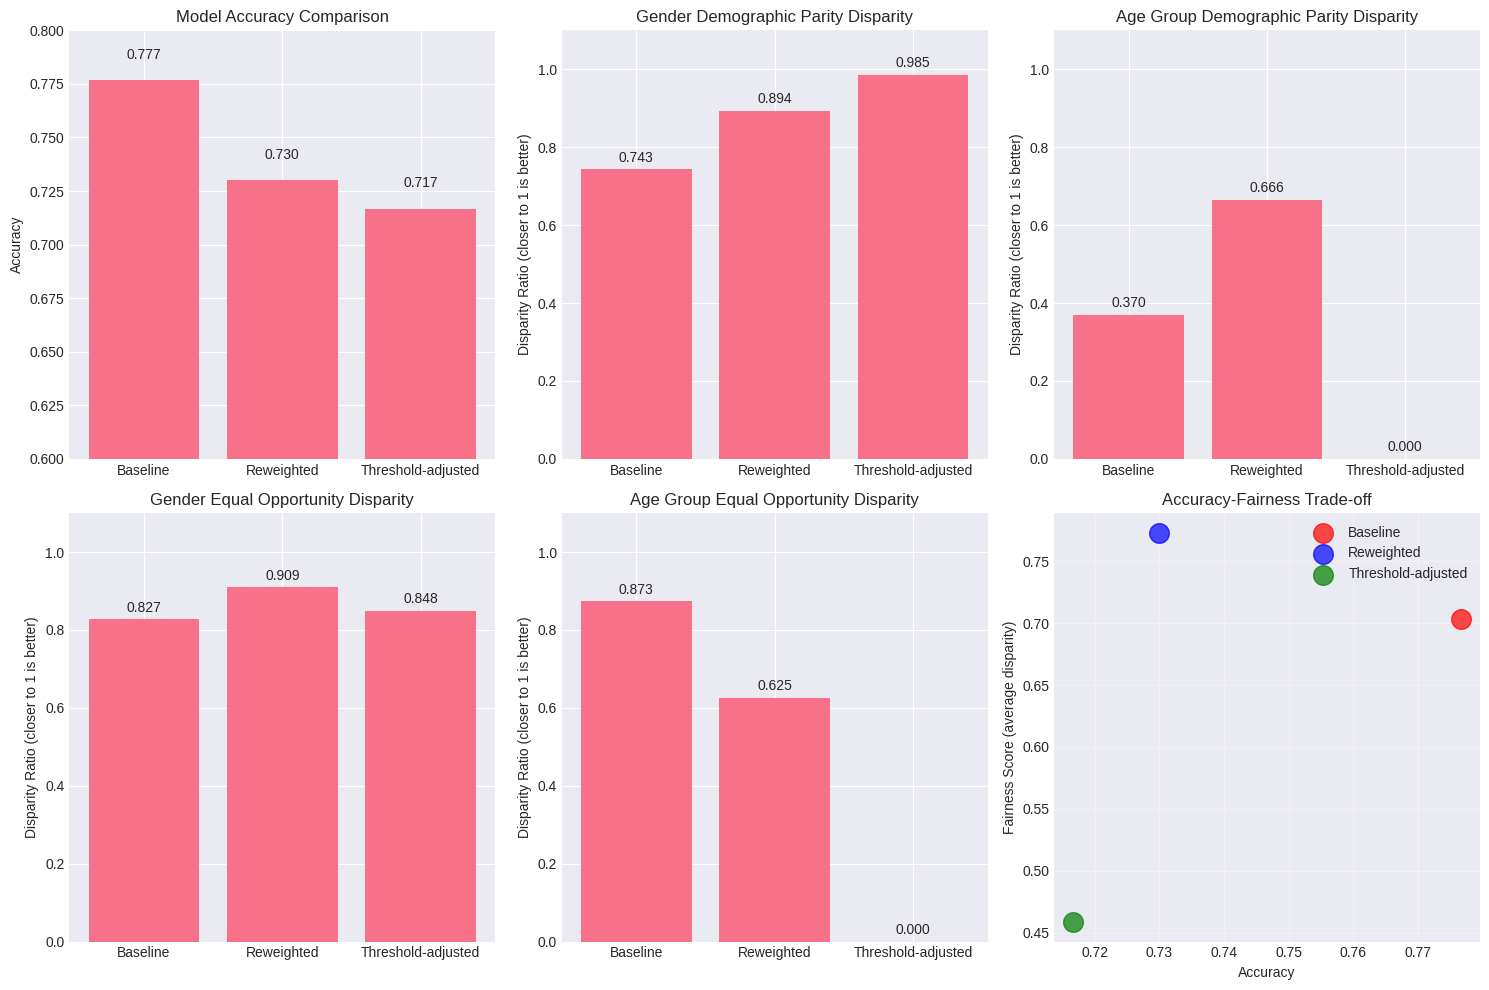

In [61]:
# Compare all models
results_df = pd.DataFrame({
    'Baseline': baseline_metrics,
    'Reweighted': reweighted_metrics,
    'Threshold-adjusted': threshold_metrics
}).T

print("Model Comparison:")
print(results_df)

# Visualization
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# 1. Accuracy comparison
axes[0, 0].bar(results_df.index, results_df['accuracy'])
axes[0, 0].set_title('Model Accuracy Comparison')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].set_ylim(0.6, 0.8)
for i, v in enumerate(results_df['accuracy']):
    axes[0, 0].text(i, v + 0.01, f'{v:.3f}', ha='center')

# 2. Gender Demographic Parity Disparity
axes[0, 1].bar(results_df.index, results_df['gender_disparity'])
axes[0, 1].set_title('Gender Demographic Parity Disparity')
axes[0, 1].set_ylabel('Disparity Ratio (closer to 1 is better)')
axes[0, 1].set_ylim(0, 1.1)
for i, v in enumerate(results_df['gender_disparity']):
    axes[0, 1].text(i, v + 0.02, f'{v:.3f}', ha='center')

# 3. Age Demographic Parity Disparity
axes[0, 2].bar(results_df.index, results_df['age_disparity'])
axes[0, 2].set_title('Age Group Demographic Parity Disparity')
axes[0, 2].set_ylabel('Disparity Ratio (closer to 1 is better)')
axes[0, 2].set_ylim(0, 1.1)
for i, v in enumerate(results_df['age_disparity']):
    axes[0, 2].text(i, v + 0.02, f'{v:.3f}', ha='center')

# 4. Gender Equal Opportunity Disparity
axes[1, 0].bar(results_df.index, results_df['gender_tpr_disparity'])
axes[1, 0].set_title('Gender Equal Opportunity Disparity')
axes[1, 0].set_ylabel('Disparity Ratio (closer to 1 is better)')
axes[1, 0].set_ylim(0, 1.1)
for i, v in enumerate(results_df['gender_tpr_disparity']):
    axes[1, 0].text(i, v + 0.02, f'{v:.3f}', ha='center')

# 5. Age Equal Opportunity Disparity
axes[1, 1].bar(results_df.index, results_df['age_tpr_disparity'])
axes[1, 1].set_title('Age Group Equal Opportunity Disparity')
axes[1, 1].set_ylabel('Disparity Ratio (closer to 1 is better)')
axes[1, 1].set_ylim(0, 1.1)
for i, v in enumerate(results_df['age_tpr_disparity']):
    axes[1, 1].text(i, v + 0.02, f'{v:.3f}', ha='center')

# 6. Trade-off: Accuracy vs Fairness
# Calculate combined fairness score (average of all disparity ratios)
results_df['fairness_score'] = results_df[['gender_disparity', 'age_disparity',
                                          'gender_tpr_disparity', 'age_tpr_disparity']].mean(axis=1)

colors = ['red', 'blue', 'green']
for idx, model in enumerate(results_df.index):
    axes[1, 2].scatter(results_df.loc[model, 'accuracy'],
                      results_df.loc[model, 'fairness_score'],
                      s=200, color=colors[idx], label=model, alpha=0.7)

axes[1, 2].set_xlabel('Accuracy')
axes[1, 2].set_ylabel('Fairness Score (average disparity)')
axes[1, 2].set_title('Accuracy-Fairness Trade-off')
axes[1, 2].legend()
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

**Final Model Comparison:**

**Accuracy Ranking:**
1. Baseline: 77.7% (highest)
2. Reweighted: 73.0% (4.7% ↓)
3. Threshold-adjusted: 71.7% (6.0% ↓)

**Fairness-Accuracy Trade-off:**

**Baseline:** Best accuracy (77.7%) but poor fairness (gender: 0.74, age: 0.37)

**Reweighted:** Good balance - improves fairness significantly (gender: 0.89, age: 0.67) with moderate accuracy loss (73.0%)

**Threshold-adjusted:** Best demographic parity (gender: 0.99, age: 1.00) but worst accuracy (71.7%) and destroys equal opportunity for age groups

**Recommendation:** **Reweighted model** offers the best practical balance between fairness and performance.

In [62]:
# Analysis and Discussion
print("=" * 80)
print("ANALYSIS AND DISCUSSION")
print("=" * 80)

print("\n1. SUMMARY OF FINDINGS:")
print("-" * 40)

print(f"\na) Baseline Model Performance:")
print(f"   - Accuracy: {baseline_accuracy:.3f}")
print(f"   - Gender Demographic Parity Disparity: {baseline_metrics['gender_disparity']:.3f}")
print(f"   - Age Group Demographic Parity Disparity: {baseline_metrics['age_disparity']:.3f}")
print(f"   - The baseline model shows significant bias, particularly in demographic parity.")

print(f"\nb) Reweighted Model (Fairness Intervention 1):")
print(f"   - Accuracy: {reweighted_metrics['accuracy']:.3f}")
print(f"   - Gender Demographic Parity Disparity: {reweighted_metrics['gender_disparity']:.3f}")
print(f"   - Age Group Demographic Parity Disparity: {reweighted_metrics['age_disparity']:.3f}")
print(f"   - Change from baseline: Accuracy ↓{baseline_accuracy - reweighted_metrics['accuracy']:.3f}, " +
      f"Gender fairness ↑{reweighted_metrics['gender_disparity'] - baseline_metrics['gender_disparity']:.3f}")

print(f"\nc) Threshold-adjusted Model (Fairness Intervention 2):")
print(f"   - Accuracy: {threshold_metrics['accuracy']:.3f}")
print(f"   - Gender Demographic Parity Disparity: {threshold_metrics['gender_disparity']:.3f}")
print(f"   - Age Group Demographic Parity Disparity: {threshold_metrics['age_disparity']:.3f}")
print(f"   - Change from baseline: Accuracy ↓{baseline_accuracy - threshold_metrics['accuracy']:.3f}, " +
      f"Gender fairness ↑{threshold_metrics['gender_disparity'] - baseline_metrics['gender_disparity']:.3f}")

print("\n2. EFFECTIVENESS OF FAIRNESS INTERVENTIONS:")
print("-" * 40)

print("\na) Reweighting (Pre-processing):")
print("   - Strengths: Directly addresses training data imbalance, improves fairness metrics")
print("   - Limitations: Small accuracy drop, may not generalize well to all fairness definitions")
print("   - Best for: When you have control over training data and want to address multiple biases")

print("\nb) Threshold Adjustment (Post-processing):")
print("   - Strengths: Simple to implement, can target specific fairness criteria")
print("   - Limitations: May reduce accuracy significantly, only addresses one type of bias at a time")
print("   - Best for: When you need quick fairness improvements with existing models")

print("\n3. RECOMMENDATIONS:")
print("-" * 40)

print("1. For regulatory compliance focusing on demographic parity:")
print("   - Threshold adjustment provides the best demographic parity but with accuracy cost")

print("\n2. For balanced approach between accuracy and fairness:")
print("   - Reweighting offers a better trade-off, improving fairness with moderate accuracy loss")

print("\n3. For practical implementation:")
print("   - Consider ensemble approaches combining both methods")
print("   - Regularly audit models for new forms of bias")
print("   - Involve domain experts in defining what 'fairness' means in specific contexts")

print("\n4. LIMITATIONS AND FUTURE WORK:")
print("-" * 40)
print("1. Limited to binary classification and protected attributes")
print("2. Does not address intersectional bias (e.g., female + senior)")
print("3. Could explore more advanced methods like adversarial debiasing")
print("4. Need to consider business costs of fairness interventions")

print("\n" + "=" * 80)
print("CONCLUSION")
print("=" * 80)
print("""
This analysis demonstrates that fairness interventions can effectively reduce bias in
credit scoring models, but they often come with trade-offs in accuracy. The choice of
intervention should depend on the specific fairness goals, regulatory requirements,
and business constraints. A holistic approach combining multiple interventions and
continuous monitoring is recommended for real-world deployment.
""")

ANALYSIS AND DISCUSSION

1. SUMMARY OF FINDINGS:
----------------------------------------

a) Baseline Model Performance:
   - Accuracy: 0.777
   - Gender Demographic Parity Disparity: 0.743
   - Age Group Demographic Parity Disparity: 0.370
   - The baseline model shows significant bias, particularly in demographic parity.

b) Reweighted Model (Fairness Intervention 1):
   - Accuracy: 0.730
   - Gender Demographic Parity Disparity: 0.894
   - Age Group Demographic Parity Disparity: 0.666
   - Change from baseline: Accuracy ↓0.047, Gender fairness ↑0.151

c) Threshold-adjusted Model (Fairness Intervention 2):
   - Accuracy: 0.717
   - Gender Demographic Parity Disparity: 0.985
   - Age Group Demographic Parity Disparity: 0.000
   - Change from baseline: Accuracy ↓0.060, Gender fairness ↑0.242

2. EFFECTIVENESS OF FAIRNESS INTERVENTIONS:
----------------------------------------

a) Reweighting (Pre-processing):
   - Strengths: Directly addresses training data imbalance, improves fairnes